# Hand Written Digit Recognisastion

### About MNIST Dataset

 The **MNIST** database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems
 
 The **MNIST** database contains 60,000 training images and 10,000 testing images.
 Photo size: **28x28 p**.

### Importing libs

In [18]:
import numpy as np
import pandas as pd

np.random.seed(0) 
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import ssl
import urllib.request
# Disable SSL verification globally
ssl._create_default_https_context = ssl._create_unverified_context

##  Reading data

In [42]:
import os

# Define the directory path
data_dir = "/Users/kartiksharma/DATA/AI DS ML/Digits Recognisation/"

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

In [43]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train = pd.read_csv("/Users/kartiksharma/DATA/AI DS ML/Digits Recognisation/train.csv")
test = pd.read_csv("/Users/kartiksharma/DATA/AI DS ML/Digits Recognisation/test.csv")

X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test
print(X_train.shape, X_test.shape)


(47859, 784) (10000, 784)


## Exploratory Data Analysis

In [44]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

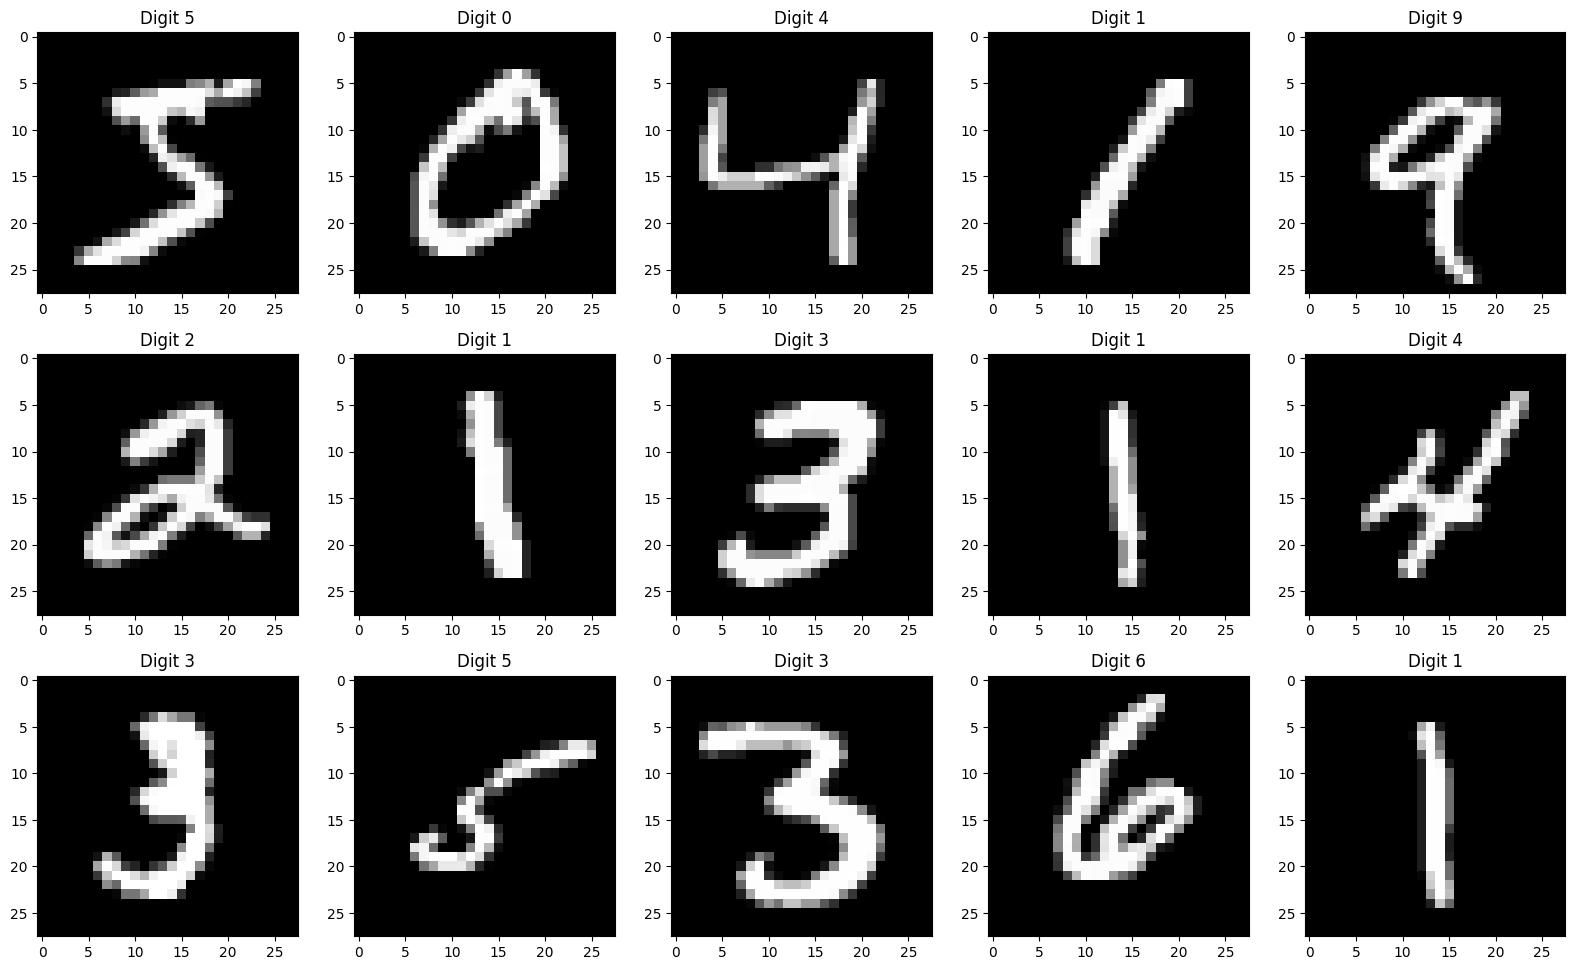

In [45]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
        
    plt.tight_layout()
    
Show_example_digits()

In [46]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

0


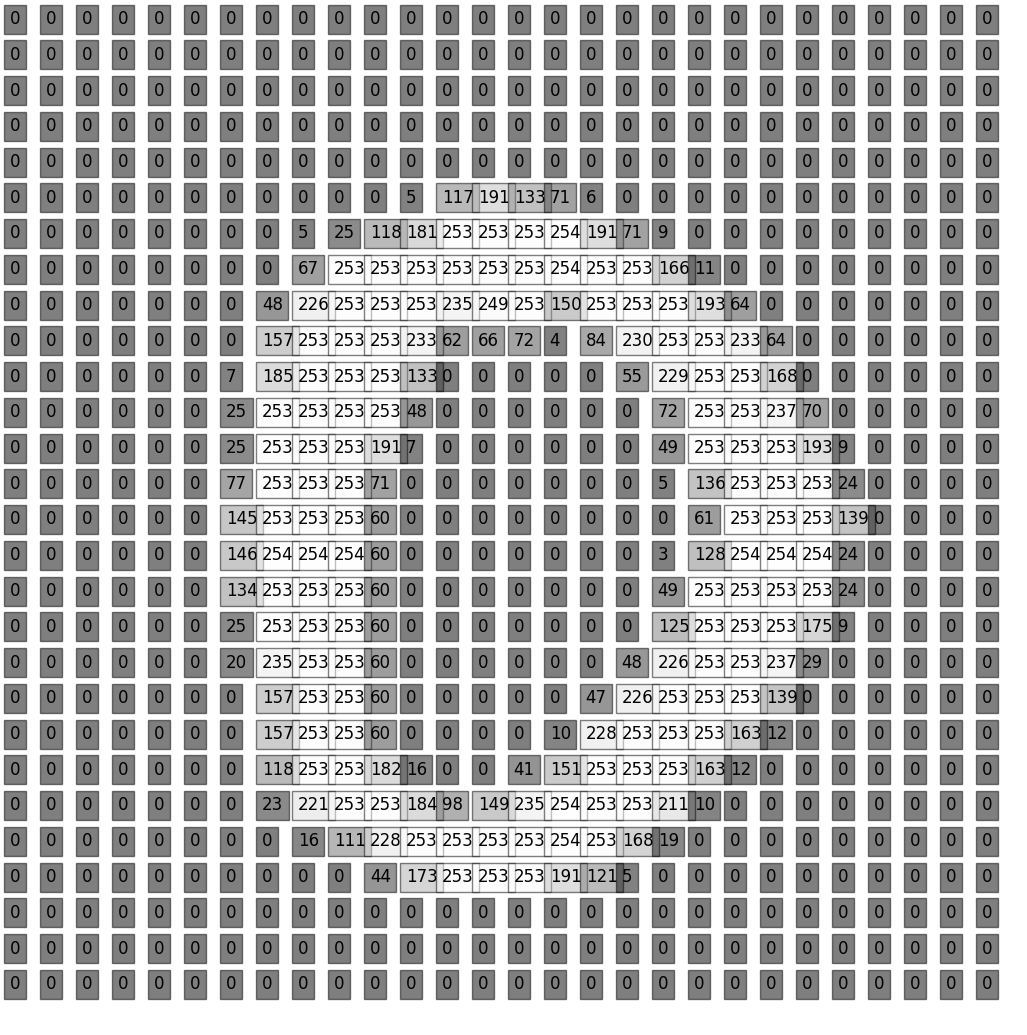

In [47]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

#### Chart of the number of digits in the data

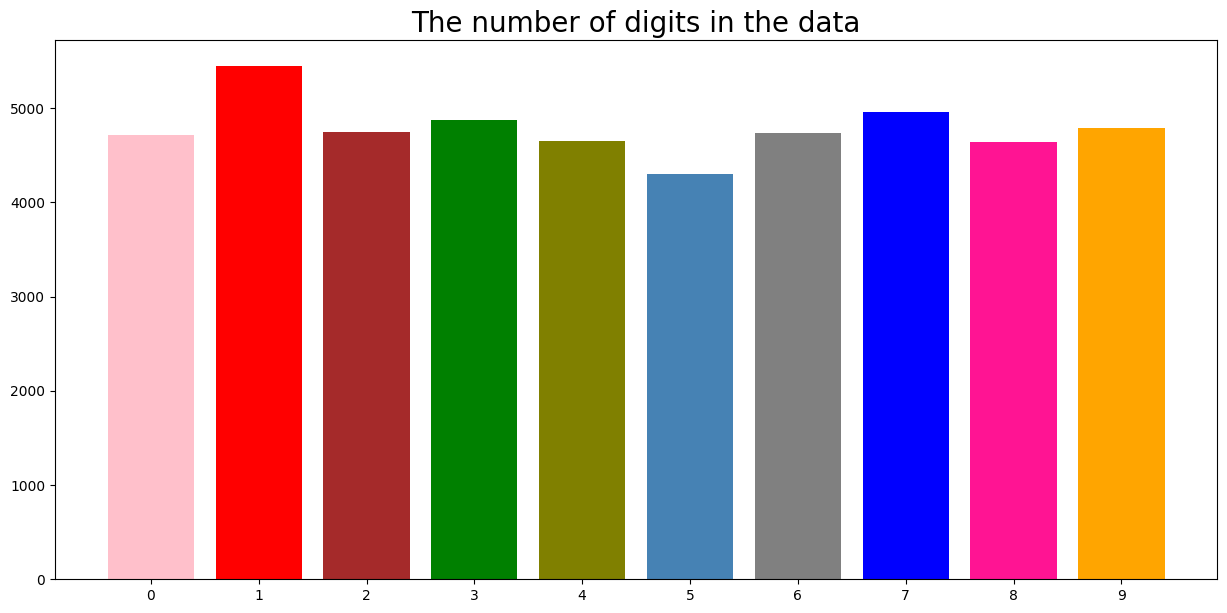

In [48]:
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

## Data Preparing

In [49]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

input_shape = (img_rows, img_cols)

In [50]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)

(47859, 784) (10000, 784)


#### Split data

added stratified folds

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

In [52]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Function to drawing learning curve history learning neural network



In [53]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

# Adding Callbacks
- EarlyStopping (Stop training when a monitored metric has stopped improving)
- ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)
- ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [60]:
def callbacks(name): 
    return [ 
        EarlyStopping(monitor='loss', patience=6), 
        ReduceLROnPlateau(monitor='loss', patience=3), 
        ModelCheckpoint(f'../working/{name}.keras', save_best_only=True)  # change .hdf5 to .keras
    ]

Our network has 407,050 params (weights)

#### Model Building

In [72]:
def get_mlpv2():
    
    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [73]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

/Users/kartiksharma/DATA/AI DS ML/Digits Recognisation/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

### Model Traning

In [68]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/40
43/43 - 5s - 112ms/step - f1: 0.7179 - loss: 0.7273 - val_f1: 0.9235 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 2/40
43/43 - 2s - 54ms/step - f1: 0.9243 - loss: 0.2559 - val_f1: 0.9500 - val_loss: 0.1684 - learning_rate: 0.0010
Epoch 3/40
43/43 - 3s - 67ms/step - f1: 0.9476 - loss: 0.1793 - val_f1: 0.9598 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 4/40
43/43 - 3s - 73ms/step - f1: 0.9590 - loss: 0.1397 - val_f1: 0.9705 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 5/40
43/43 - 4s - 85ms/step - f1: 0.9674 - loss: 0.1088 - val_f1: 0.9716 - val_loss: 0.0988 - learning_rate: 0.0010
Epoch 6/40
43/43 - 4s - 102ms/step - f1: 0.9692 - loss: 0.0971 - val_f1: 0.9771 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 7/40
43/43 - 4s - 103ms/step - f1: 0.9743 - loss: 0.0802 - val_f1: 0.9767 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 8/40
43/43 - 3s - 72ms/step - f1: 0.9770 - loss: 0.0745 - val_f1: 0.9779 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 9/40
43/43 - 5s

### Performance Evaluation


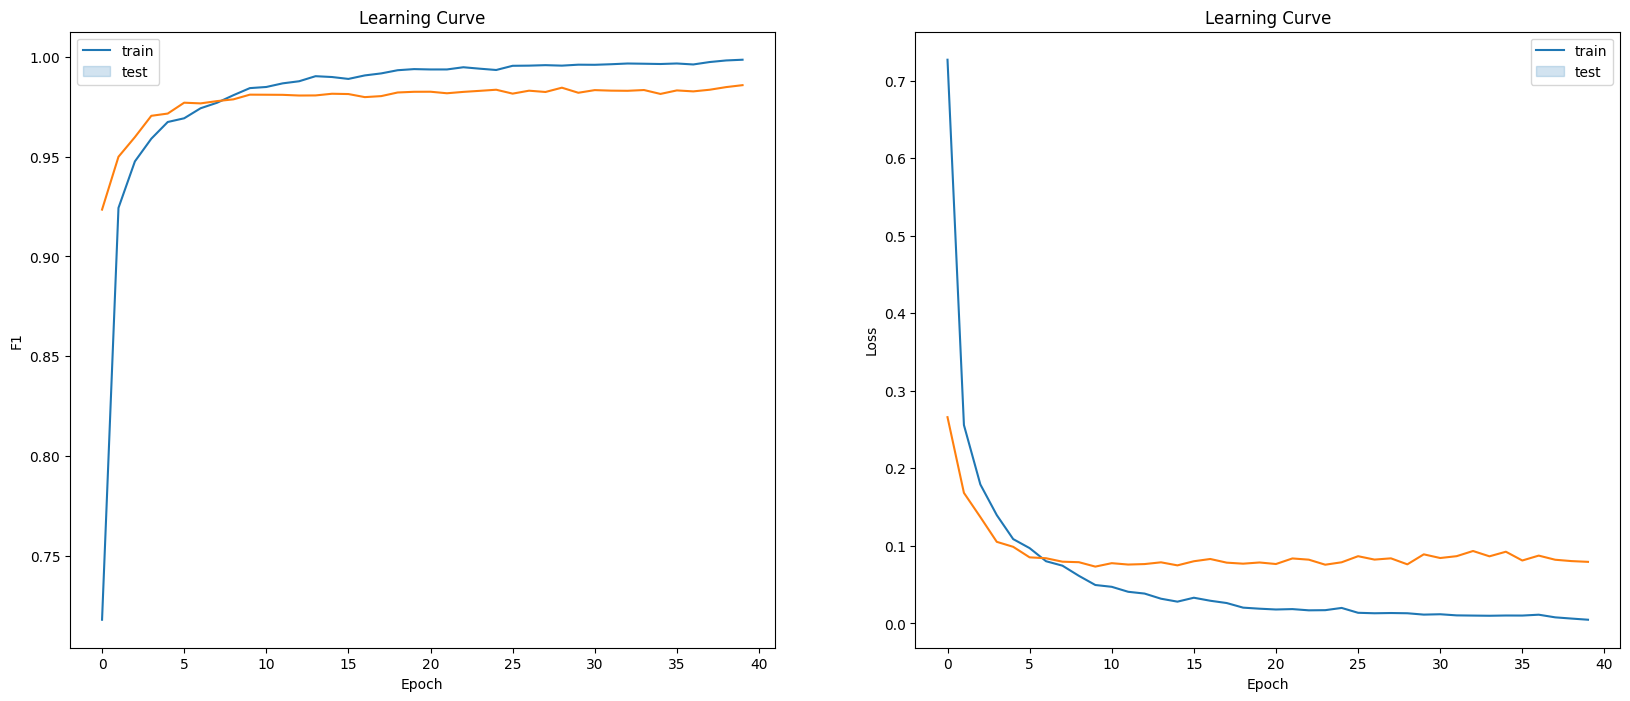

In [70]:
draw_learning_curve(learning_history)

In [71]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 7.941705733537674%
Test score: 98.55092167854309%
MLP Error: 1.45%


# Thank You